# Pet Classification with CNN
<b>Student</b>: Lorenzo Severini<b>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Course</b>: Computer Vision and Image Processing M

# Project Overview
The goal of this project is to implement a neural network that classifies images of 37 breeds of cats
and dogs from the Oxford-IIIT-Pet dataset. The project is divided into two tasks: first, you will be
asked to implement from scratch your own neural network for image classification; then, you will
fine-tune a pre-trained network provided by Keras.

## Dataset
### Overview
The dataset you will be using contains images of pets.

![dataset overview](img-report/dataset-overview.png "Dataset OVeerview")

You can download the dataset at the following URL: https://www.robots.ox.ac.uk/~vgg/data/pets/.

### Content
The repository contains a 37-category pet dataset with roughly 200 images for each class. The
images have a large variation in scale, pose and lighting. All images have an associated ground
truth annotation of breed. The dataset is already split into training, validation and testing. You
should use only the training and validation splits for development in both the first and second tasks.

# Second Task: fine-tune an existing network

Your goal is to fine-tune a pre-trained ResNet-18 model on the Oxford-IIIT-Pet Dataset. Use the
implementation provided by Keras; do not implement it yourselves (i.e. exactly what you could
not do in the first task). Specifically, you must use the Keras ResNet-18 model pre-trained on
ImageNet-1K.

Divide your fine-tuning into two parts:
<ol>
<li>First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best
model in the first task of the project;</li>
<li>Then, tweak the training hyperparameters in order to increase the accuracy on the validation
split of the Oxford-IIIT-Pet Dataset. Justify your choices by analysing the training plots
and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos,
or whatever else you find enlightening). You should consider yourself satisfied once you obtain
a classification accuracy on the validation split between 80 and 90%.</li>
</ol>

## Library Installation

To comply with the project requirement of using <b>ResNet-18</b> (which is not available in the standard <code>tf.keras.applications</code> module), I installed the <code>classification-models-3D</code> library.

This package provides a Keras implementation of ResNet-18 with pre-trained ImageNet weights, allowing me to perform fine-tuning effectively.

In [30]:
!pip install classification-models-3D

## Imports & Reproducibility

Standard libraries for file manipulation (<code>os</code>, <code>shutil</code>), numerical operations (<code>numpy</code>), and deep learning (<code>tensorflow</code>) are imported.
<ul>
    <li><b>Reproducibility</b>: I set a global <code>SEED = 42</code> for both NumPy and TensorFlow to ensure that random operations (like weight initialization and data shuffling) yield consistent results across different runs.</li>
    <li><b>Classification Models</b>: The <code>Classifiers</code> class is imported to access the ResNet-18 architecture.</li>
</ul>

In [31]:
import os
import tarfile
import shutil
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from classification_models.keras import Classifiers

# setting seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

## Visualization Utility

I defined a helper function <code>plot_best_model</code> to visualize the training history saved in the CSV logs.
<ul>
    <li><b>Functionality</b>: It reads the training log and plots two graphs: <b>Loss over Epochs</b> and <b>Accuracy over Epochs</b>.</li>
    <li><b>Best Epoch Tracking</b>: It automatically identifies and highlights the epoch with the lowest <code>val_loss</code> (marked with a red dot), printing the exact metrics for that specific point. This helps in quickly assessing the model's peak performance.</li>
</ul>

In [32]:
import pandas as pd

def plot_best_model(best_model_history_name):
    if os.path.exists(best_model_history_name):
        # load data
        df = pd.read_csv(best_model_history_name)
        
        # find best epoch based on min validation loss
        best_idx = df['val_loss'].idxmin()
        best_row = df.iloc[best_idx]

        # print stats for the best epoch
        print("--- Best Model Results ---")
        print(f"Best Epoch: {int(best_row['epoch']) + 1}")
        print(f"Val Loss: {best_row['val_loss']:.4f}")
        print(f"Val Accuracy: {best_row['val_accuracy']:.2%}")
        print(f"Train Loss: {best_row['loss']:.4f}")
        print(f"Train Accuracy: {best_row['accuracy']:.2%}")

        # setup figure size
        plt.figure(figsize=(14, 5))

        # plot 1: loss
        plt.subplot(1, 2, 1)
        plt.plot(df['epoch'], df['loss'], label='Train Loss')
        plt.plot(df['epoch'], df['val_loss'], label='Val Loss')
        
        # mark the best epoch with a red dot
        plt.scatter(best_row['epoch'], best_row['val_loss'], color='red', label='Best Epoch')
        plt.title('Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # plot 2: accuracy
        plt.subplot(1, 2, 2)
        plt.plot(df['epoch'], df['accuracy'], label='Train Acc')
        plt.plot(df['epoch'], df['val_accuracy'], label='Val Acc')

        # mark the best epoch here too
        plt.scatter(best_row['epoch'], best_row['val_accuracy'], color='red', label='Best Epoch')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.show()

    else:
        print(f"File {best_model_history_name} not found.")

## Path Configuration

I defined absolute paths for the dataset directories to keep the code organized.
<ul>
    <li><b>Base Paths</b>: <code>images_dir_path</code> and <code>annots_dir_path</code> point to the raw extracted data.</li>
    <li><b>Split Paths</b>: I created specific variables <code>train_val_path</code> and <code>test_path</code> for the reorganized data folders, which will be populated by the splitting script.</li>
</ul>

In [33]:
# path configuration
dataset_dir_path = os.path.join('../', 'oxford-pet')

images_dir_path = os.path.join(dataset_dir_path, 'images')
annots_dir_path = os.path.join(dataset_dir_path, 'annotations')

# defining separate folders for the official splits
train_val_path = os.path.join(dataset_dir_path, 'train_val')
test_path = os.path.join(dataset_dir_path, 'test')

## Environment & GPU Setup

I verify the Python and TensorFlow versions to ensure compatibility.

<b>GPU Configuration</b>: To prevent TensorFlow from allocating all available Video RAM at startup (which can cause OOM errors on some systems), I enabled <b>memory growth</b> using <code>set_memory_growth(gpu, True)</code>. 
    
This allows the runtime to allocate memory dynamically as needed.</li>


In [34]:
print(f"Python Version: {sys.version.split()[0]}")
print(f"TensorFlow Version: {tf.__version__}")
print("Device:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

try:
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError:
    pass 

Python Version: 3.10.19
TensorFlow Version: 2.15.1
Device: GPU


## Dataset Download and Extraction

This block automates the data retrieval process.
<ul>
    <li><b>Check & Download</b>: The script checks if the <code>images</code> and <code>annotations</code> folders already exist. If not, it uses <code>tf.keras.utils.get_file</code> to download the official archives from the <b>Oxford-IIT-Pet Dataset</b>.</li>
    <li><b>Extraction</b>: It extracts the <code>.tar.gz</code> archives and automatically removes the compressed files to save disk space.</li>
</ul>

In [35]:
def download_and_extract(url, dest_folder, filename):
    # create the folder if not exists
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    archive_path = os.path.join(dest_folder, filename)
    
    # downloading archive
    print(f"Downloading {filename}...")
    tf.keras.utils.get_file(
        fname=filename,
        origin=url,
        cache_dir='.', 
        cache_subdir=dest_folder # downloads directly into the folder
    )
    
    # extracting (python handles .tar.gz in one step)
    print(f"Extracting {filename}...")
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(path=dest_folder)
        
    # removing the zip file to clean up
    print(f"Removing {filename} to save space...")
    os.remove(archive_path)

# check if images exist
if not os.path.exists(images_dir_path):
    url_images = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
    download_and_extract(url_images, dataset_dir_path, 'images.tar.gz')
else:
    print("Images already present.")

# check if annotations exist
if not os.path.exists(annots_dir_path):
    url_annots = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
    download_and_extract(url_annots, dataset_dir_path, 'annotations.tar.gz')
else:
    print("Annotations already present.")

Images already present.
Annotations already present.


## Dataset Organization

Since Keras requires images to be organized in subfolders by class (e.g., <code>class_name/image.jpg</code>), I implemented a custom function <code>create_split</code>.
<ul>
    <li><b>Parsing</b>: It reads the official split files (<code>trainval.txt</code> and <code>test.txt</code>) provided with the dataset.</li>
    <li><b>Class Extraction</b>: It extracts the class label from the filename (e.g., converts <code>Abyssinian_1.jpg</code> &rarr; class <code>Abyssinian</code>).</li>
    <li><b>File Organization</b>: It copies the images into a directory structure compatible with <code>image_dataset_from_directory</code>. This ensures we are training and testing on the exact same splits intended by the dataset authors.</li>
</ul>

In [36]:
def create_split(annots_filename, dest_path):
    # path to the list file (e.g. annotations/trainval.txt)
    annots_file_path = os.path.join(annots_dir_path, annots_filename)
    
    # check if destination already exists to avoid re-copying

    if os.path.exists(dest_path):
        print(f"Split {os.path.basename(dest_path)} already exists.")
        return

    print(f"Creating split in {dest_path}...")
    os.makedirs(dest_path, exist_ok=True)
    
    # reading the list file
    with open(annots_file_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        parts = line.strip().split()
        if not parts: continue
            
        # parsing the line: "Abyssinian_1 1 1 1"
        filename_no_ext = parts[0]
        filename = filename_no_ext + ".jpg"
        
        # getting class name (everything before the last underscore)
        # for example, "Abyssinian_1" -> "Abyssinian"
        class_name = "_".join(filename_no_ext.split('_')[:-1])
        
        # defining source and destination paths
        src_file = os.path.join(images_dir_path, filename)
        dest_folder = os.path.join(dest_path, class_name)
        dest_file = os.path.join(dest_folder, filename)
        
        # copy file only if it exists in source
        if os.path.exists(src_file):
            if not os.path.exists(dest_folder):
                os.makedirs(dest_folder)
            shutil.copy(src_file, dest_file)

# executing the splits
# trainval.txt -> train_val folder
# test.txt -> test folder
if os.path.exists(images_dir_path) and os.path.exists(annots_dir_path):
    create_split('trainval.txt', train_val_path)
    create_split('test.txt', test_path)
    print("Dataset splitting complete.")
else:
    print("ERROR: images or annotations not found. Run the download block first.")

Split train_val already exists.
Split test already exists.
Dataset splitting complete.


## Hyperparameters Configuration

I defined the global constants for the training process.
<ul>
    <li><b>Consistency</b>: To strictly follow the assignment instructions for <b>Part 1</b>, I am using the exact same <code>IMG_SIZE = (224, 224)</code> and <code>BATCH_SIZE = 32</code> that I used for my best model in the previous task (Task 1).</li>
    <li><b>Epochs</b>: Set to <code>200</code>, relying on Early Stopping to halt training at the right time.</li>
</ul>

In [37]:
# config (same as task 1)
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32       
NUM_CLASSES = 37
NUM_EPOCHS = 200

## Data Augmentation Pipeline

I reused the exact augmentation sequence from Task 1 to ensure a fair comparison during the first phase of fine-tuning.
<ul>
    <li><b>Layers</b>: The pipeline includes <code>RandomFlip</code>, <code>RandomRotation</code>, <code>RandomTranslation</code>, and <code>RandomContrast</code>.</li>
    <li><b>Purpose</b>: These transformations artificially increase the diversity of the training set, helping the model generalize better and preventing overfitting on the relatively small <b>Oxford-IIIT Pet Dataset</b>.</li>
</ul>

In [38]:
# data augmentation (from task 1)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
], name="augmentation")

## Data Loading and Optimization

I used <code>image_dataset_from_directory</code> to load the data from the organized folders.
<ul>
    <li><b>Train/Val Split</b>: Following standard practice, I further split the official <code>train_val</code> set into <b>80% training</b> and <b>20% validation</b> to monitor performance during development.</li>
    <li><b>Performance Optimization</b>: I applied <code>.cache()</code> to keep images in memory after the first epoch and <code>.prefetch(buffer_size=AUTOTUNE)</code> to prepare the next batch while the GPU is processing the current one, significantly reducing training time.</li>
</ul>

In [39]:
print(f"Loading data from: {train_val_path}")

AUTOTUNE = tf.data.AUTOTUNE

# training dataset
print("Creating Training Split...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=None,
    shuffle=True
)

# saving class names before transformations
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes found: {num_classes}")

# optimized training pipeline
train_ds = train_ds.cache()       # keeps in RAM
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

# # validation dataset
print("Creating Validation Split...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=None, # None qui
    shuffle=False
)

# optimized validation pipeline
val_ds = val_ds.cache()
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("Data pipeline finalized.")

Loading data from: ../oxford-pet/train_val
Creating Training Split...
Found 3680 files belonging to 37 classes.
Using 2944 files for training.
Classes found: 37
Creating Validation Split...
Found 3680 files belonging to 37 classes.
Using 736 files for validation.
Data pipeline finalized.


## Loading Pre-trained ResNet-18

I instantiated the ResNet-18 model using the <code>classification_models</code> library.
<ul>
    <li><b>Weights</b>: Loaded with <code>weights='imagenet'</code> to leverage the features learned on the massive ImageNet dataset.</li>
    <li><b>Feature Extractor</b>: I set <code>include_top=False</code> to discard the original 1000-class classification head.</li>
    <li><b>Freezing</b>: I explicitly set <code>backbone.trainable = False</code>. This <b>freezes</b> all the weights in the convolutional base, ensuring that during the initial training phase, we only update the weights of our new custom head. This prevents destroying the pre-learned features with large gradient updates.</li>
</ul>

In [40]:
print("Loading ResNet18...")

# load resnet18
# get model and its specific preprocessing function
ResNet18, preprocess_input = Classifiers.get('resnet18')

# load weights, exclude top layer (1000 classes)
backbone = ResNet18(input_shape=IMG_SIZE + (3,), weights='imagenet', include_top=False)

# freeze weights to tune the classification head
backbone.trainable = False

Loading ResNet18...


## Model Architecture Assembly

I used the Keras Functional API to build the final model pipeline:
<ol>
    <li><b>Input & Augmentation</b>: The model starts with the input layer followed by the data augmentation block.</li>
    <li><b>Preprocessing</b>: <i>Crucially</i>, I applied the specific <code>preprocess_input</code> function required by the ResNet-18 library to normalize inputs correctly.</li>
    <li><b>Backbone</b>: The processed inputs are passed through the frozen ResNet-18 base.</li>
    <li><b>Classification Head</b>: I added a <code>GlobalAveragePooling2D</code> layer to vectorize the features, followed by a <code>Dropout(0.5)</code> for regularization (same as Task 1), and a final <code>Dense</code> layer with <b>37 units</b> (Softmax) for the pet breeds.</li>
</ol>

In [ ]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

# augmentation
x = data_augmentation(inputs)

# preprocessing (critical for this library)
x = preprocess_input(x)

# backbone
x = backbone(x, training=False)

# custom head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)                  # same dropout as task 1
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs, name="resnet18_task2_p1")
model.summary()

Model: "resnet18_task2_p1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 model_1 (Functional)        (None, 7, 7, 512)         11186889  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 37)                18981     
                                                 

## Model Compilation

I compiled the model with the configuration required for Part 1:
<ul>
    <li><b>Optimizer</b>: <code>Adam</code> with a learning rate of <code>1e-4</code>. This matches the best configuration found in Task 1.</li>
    <li><b>Loss Function</b>: <code>sparse_categorical_crossentropy</code> is used since our labels are integers (class indices).</li>
    <li><b>Metrics</b>: We monitor <code>accuracy</code> to evaluate the classification performance.</li>
</ul>

In [42]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Callbacks Configuration

To manage the training process effectively, I defined the following callbacks:
<ul>
    <li><b>PlotLossesKeras</b>: For real-time plotting of loss and accuracy (in order to better monitor training).</li>
    <li><b>EarlyStopping</b>: Stops training if validation loss doesn't improve for <b>15 epochs</b>, restoring the best weights.</li>
    <li><b>ReduceLROnPlateau</b>: Reduces the learning rate by a factor of <code>0.5</code> if validation loss stagnates for 5 epochs, helping the model converge to a better minimum.</li>
    <li><b>ModelCheckpoint</b> & <b>CSVLogger</b>: Saves the best model weights and records the training history for the final report.</li>
</ul>

In [43]:
from livelossplot import PlotLossesKeras
from datetime import datetime

run_id = "run_task2_" + datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join("runs", run_id)
os.makedirs(run_dir, exist_ok=True)

best_model_name_p1 = os.path.join(run_dir, 'best_model_part1.keras')
best_model_history_name_p1 = os.path.join(run_dir, "best_model_history_part1.csv")

# callbacks
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,               # wait N epochs before stopping
        restore_best_weights=True, # go back to the best model found
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,                # multiply lr by X on reduce
        patience=5,                # wait N epochs before reducing leraning rate
        min_lr=1e-6,               # lower bound for lr
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        best_model_name_p1,
        monitor='val_loss',
        save_best_only=True,       # save only if it beats previous best
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger(
    best_model_history_name_p1, 
    separator=',', 
    append=True
    )
]

## Phase 1: Training (Feature Extraction)

The first phase of training focuses exclusively on the custom classification head.
<ul>
    <li><b>Frozen Backbone</b>: Since <code>backbone.trainable</code> was set to <code>False</code>, the weights of the ResNet-18 base remain static. The model uses the pre-learned ImageNet features to extract patterns from the pet images.</li>
    <li><b>Objective</b>: The goal is to initialize the weights of our new <code>Dense</code> layer and <code>BatchNormalization</code> layers without disturbing the pre-trained convolutional filters. Training a randomly initialized head alongside an unfrozen backbone could induce large gradient updates that might destroy the pre-learned features.</li>
</ul>

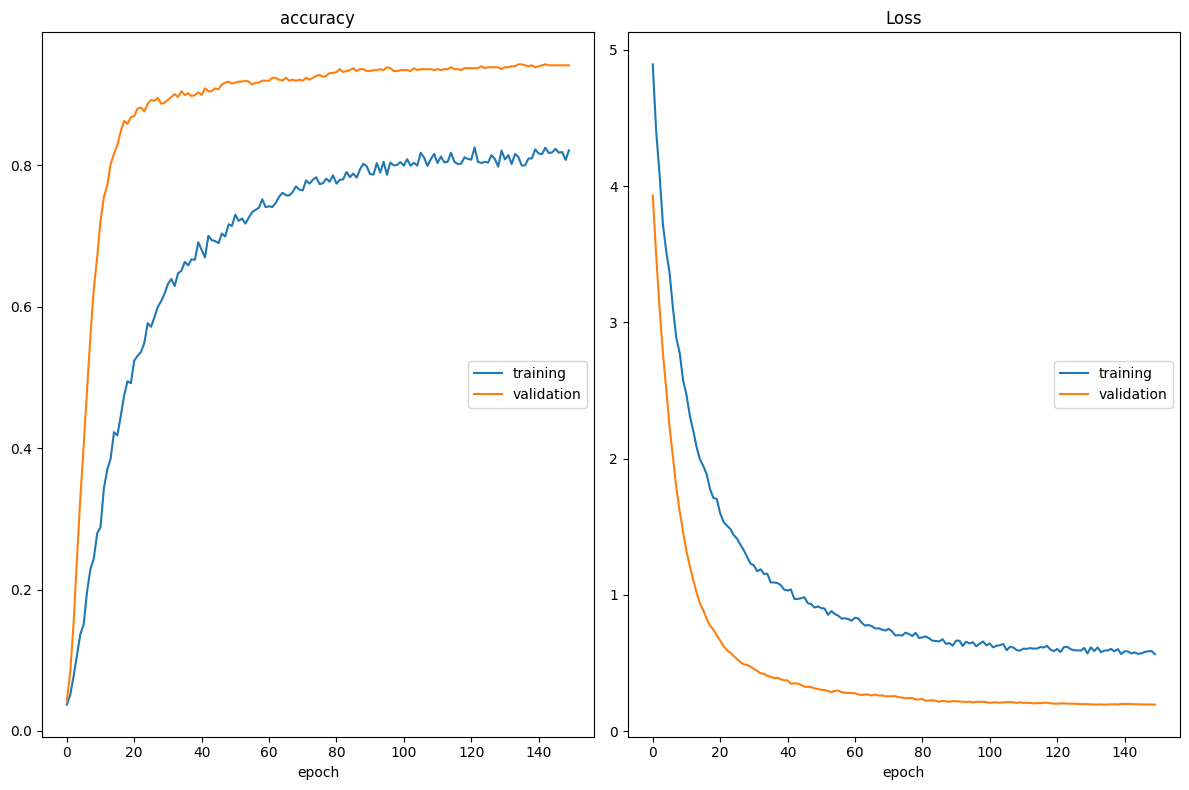

accuracy
	training         	 (min:    0.037, max:    0.825, cur:    0.821)
	validation       	 (min:    0.042, max:    0.943, cur:    0.942)
Loss
	training         	 (min:    0.564, max:    4.893, cur:    0.564)
	validation       	 (min:    0.194, max:    3.931, cur:    0.194)
Restoring model weights from the end of the best epoch: 135.

Epoch 150: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 150: val_loss did not improve from 0.19375
92/92 [==============================] - 5s 56ms/step - loss: 0.5644 - accuracy: 0.8213 - val_loss: 0.1944 - val_accuracy: 0.9416 - lr: 6.2500e-06
Epoch 150: early stopping


In [44]:
# training
print("Starting task 2 (part 1) training...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,              # early stopping will handle the end
    callbacks=callbacks,
    verbose=1
)

## Phase 2: Fine-Tuning the Full Network

Having established a stable baseline with the feature extractor, already achieving 90%+ accuracy, I proceeded to the <b>Fine-Tuning</b> phase to boost performance even more.

<b>Strategy:</b>
<ol>
    <li><b>Unfreeze</b>: We make the entire ResNet-18 backbone trainable. This allows the convolutional filters to adapt specifically to the <i>Oxford-IIIT Pet</i> dataset (e.g., learning to distinguish specific fur textures or ear shapes rather than generic ImageNet objects).</li>
    <li><b>Low Learning Rate</b>: I drastically reduce the learning rate to <code>1e-5</code>. This ensures that I fine-tune the weights with tiny updates, preserving the robust prior knowledge of the network.</li>
</ol>

### Unfreezing the Backbone

I enabled gradient updates for the entire network by setting <code>backbone.trainable = True</code>.

In [48]:
backbone.trainable = True

### Callbacks Configuration

To strictly separate the results of the two phases, I defined a new set of callbacks pointing to different files.
<ul>
    <li><b>Separate Logs</b>: The training history is saved to <code>best_model_history_part2.csv</code> and the weights to <code>best_model_part2.keras</code>. This prevents overwriting the Phase 1 checkpoints.</li>
    <li><b>Persistence</b>: <code>EarlyStopping</code> and <code>ReduceLROnPlateau</code> are kept active to prevent overfitting as the model becomes more complex and capable.</li>
</ul>

In [49]:
from livelossplot import PlotLossesKeras
from datetime import datetime

# same directory as part 1
# different model and history names

best_model_name_p2 = os.path.join(run_dir, 'best_model_part2.keras')
best_model_history_name_p2 = os.path.join(run_dir, "best_model_history_part2.csv")

# callbacks
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,               # wait N epochs before stopping
        restore_best_weights=True, # go back to the best model found
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,                # multiply lr by X on reduce
        patience=5,                # wait N epochs before reducing leraning rate
        min_lr=1e-6,               # lower bound for lr
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        best_model_name_p2,
        monitor='val_loss',
        save_best_only=True,       # save only if it beats previous best
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger(
        best_model_history_name_p2, 
        separator=',', 
        append=True
    )
]

### Full Network Training

I executed the training for the entire network.
<ul>
    <li><b>Convergence</b>: With the backbone unfrozen, the model can now adjust its internal feature representations. I expect the validation accuracy to break the previous plateau and increase its accuracy by 1-2%.</li>
    <li><b>Initial Epoch</b>: Note that while I start a fresh <code>fit</code> call, the weights are <b>not</b> reset; training continues from where Phase 1 left off, but with a "reconfigured" architecture.</li>
</ul>

Here the learning rate is lowered from <code>1e-4</code> to <code>1e-5</code>.

In [50]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

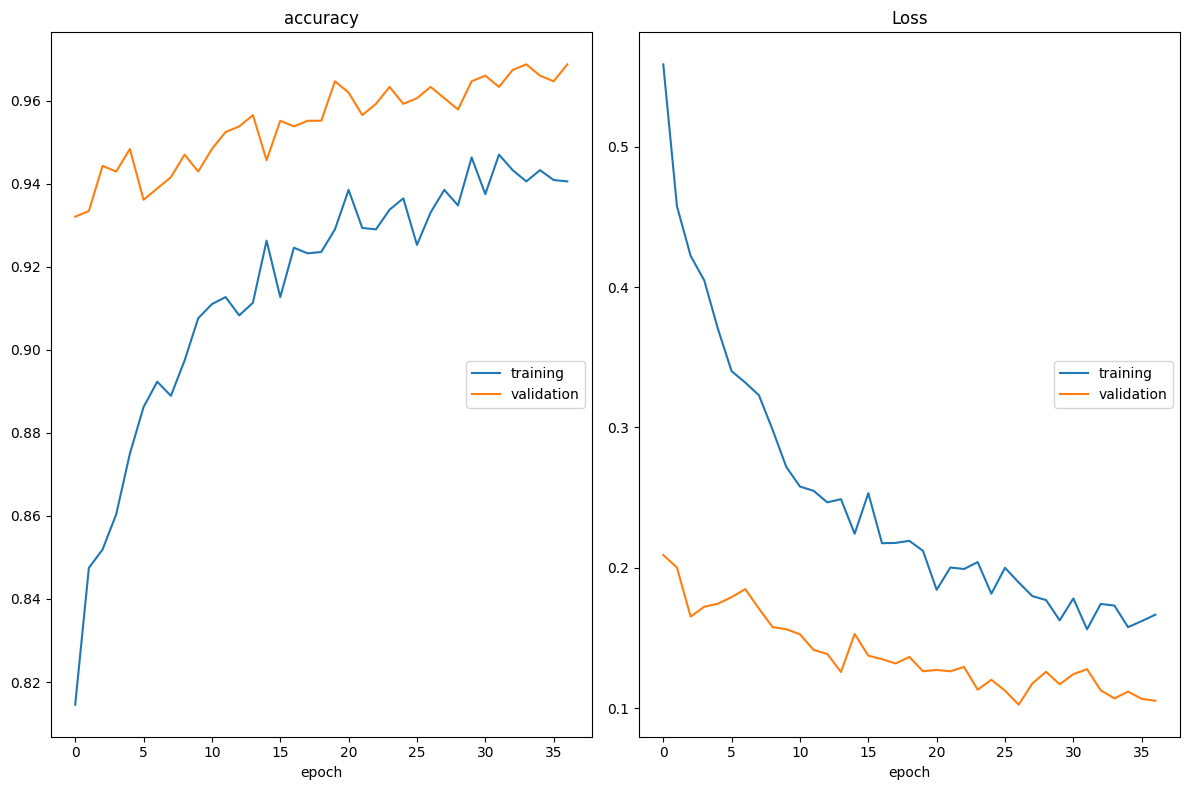

accuracy
	training         	 (min:    0.815, max:    0.947, cur:    0.941)
	validation       	 (min:    0.932, max:    0.969, cur:    0.969)
Loss
	training         	 (min:    0.156, max:    0.559, cur:    0.167)
	validation       	 (min:    0.102, max:    0.209, cur:    0.105)
Restoring model weights from the end of the best epoch: 27.

Epoch 37: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 37: val_loss did not improve from 0.10238
92/92 [==============================] - 13s 141ms/step - loss: 0.1665 - accuracy: 0.9406 - val_loss: 0.1052 - val_accuracy: 0.9688 - lr: 1.2500e-06
Epoch 37: early stopping


In [51]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

# Performance Visualization and Analysis

Finally, I utilized the `plot_best_model` utility to analyze the learning curves for both phases.
<ul>
    <li><b>Phase 1 Analysis</b>: Shows how quickly the custom head adapted to the frozen features, reaching an accuracy of <b>94.16%</b>.</li>
    <li><b>Phase 2 Analysis</b>: Demonstrates the gain achieved by fine-tuning. We look for a decrease in Validation Loss and a corresponding increase in Accuracy, reaching an incredible <b>96.88%</b> without overfitting.</li>
</ul>

--- Best Model Results ---
Best Epoch: 135
Val Loss: 0.1938
Val Accuracy: 94.29%
Train Loss: 0.5906
Train Accuracy: 81.18%


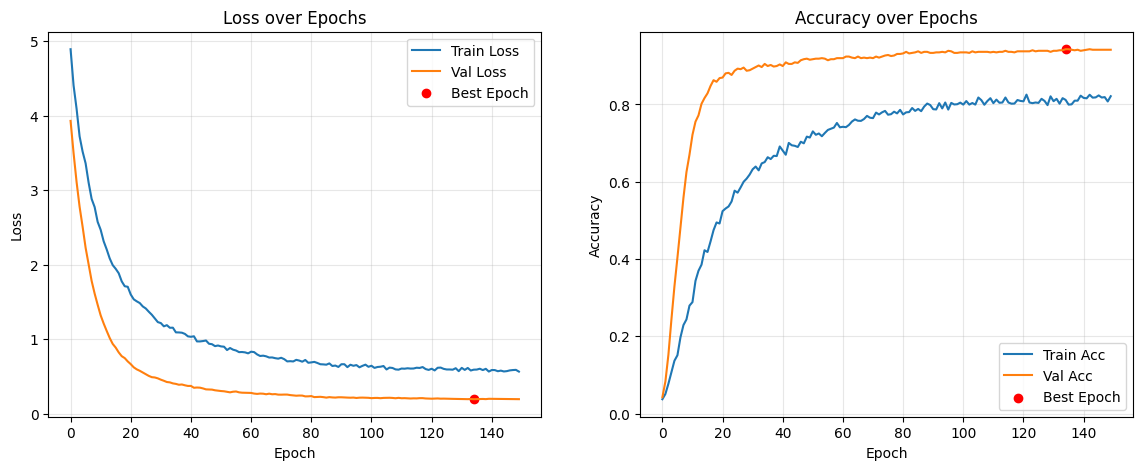

In [ ]:
plot_best_model(best_model_history_name_p1)

--- Best Model Results ---
Best Epoch: 27
Val Loss: 0.1024
Val Accuracy: 96.33%
Train Loss: 0.1895
Train Accuracy: 93.31%


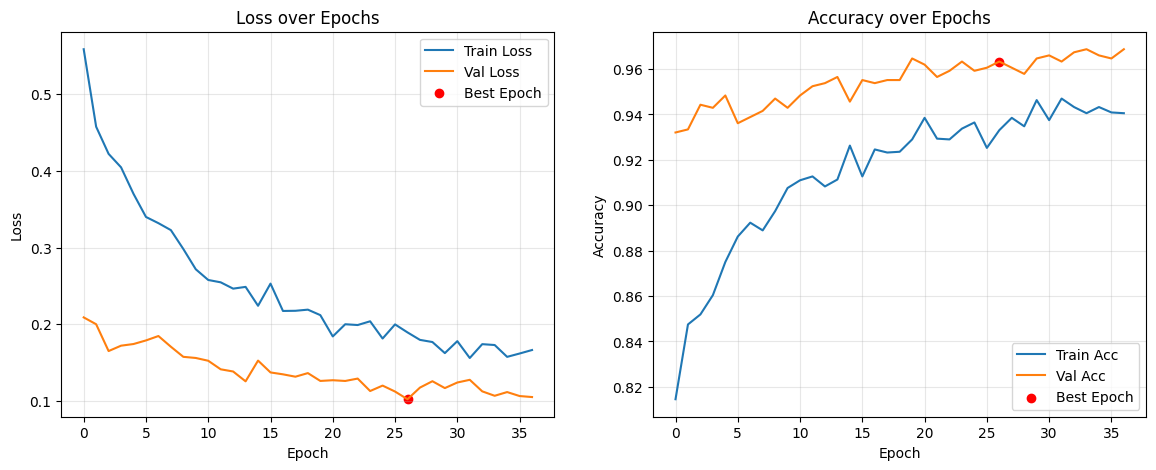

In [52]:
plot_best_model(best_model_history_name_p2)